## Getting insights from the Timestamp variable

Here's an in-depth analysis of the Timestamp variable in this first-of-its-kind code competition.
The first few code cells are just general EDA, as that's what this used to be before I decided to go more in-depth into the time aspect :)

Any feedback or upvotes are very much appreciated!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
p = sns.color_palette()

In [2]:
with pd.HDFStore("../input/train.h5", "r") as train:
    df = train.get("train")

In [3]:
print('Number of rows: {}, Number of columns: {}'.format(*df.shape))

Number of rows: 1710756, Number of columns: 111


In [4]:
cols = [0, 0, 0]
for c in df.columns:
    if 'derived' in c: cols[0] += 1
    if 'fundamental' in c: cols[1] += 1
    if 'technical' in c: cols[2] += 1
print('Derived columns: {}, Fundamental columns: {}, Technical columns: {}'.format(*cols))
print('\nColumn dtypes:')
print(df.dtypes.value_counts())
print('\nint16 columns:')
print(df.columns[df.dtypes == 'int16'])

Derived columns: 5, Fundamental columns: 63, Technical columns: 40

Column dtypes:
float32    109
int16        2
dtype: int64

int16 columns:
Index(['id', 'timestamp'], dtype='object')


Here we can see that we have 111 columns, of which the only ones with integer values are the IDs and the timestamp. The other features are split into three categories, which we will look at in more detail later. Let's look at the target value first.

##Target

Target value min -0.086 max 0.093 mean 0.000 std 0.022


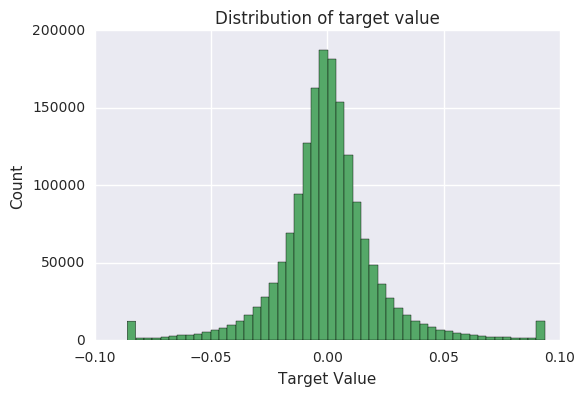

In [5]:
y = df['y'].values
plt.hist(y, bins=50, color=p[1])
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Distribution of target value')
print('Target value min {0:.3f} max {1:.3f} mean {2:.3f} std {3:.3f}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

So we have what looks like a target value which is normally distributed around a mean of (exactly) 0 with a standard deviation of .022. Interestingly, there is a small peak at the start and end of the distribution.

In [6]:
print('Number of unique target values: {}'.format(len(set(y))))

Number of unique target values: 1672946


Looks like almost all of the target values that we see here are unique to only that row. It doesn't look like any binning has occured here - I was half expecting the peaks at the start and end of the distribution to be a single value, a number which signified "out of bounds".

## Timestamp

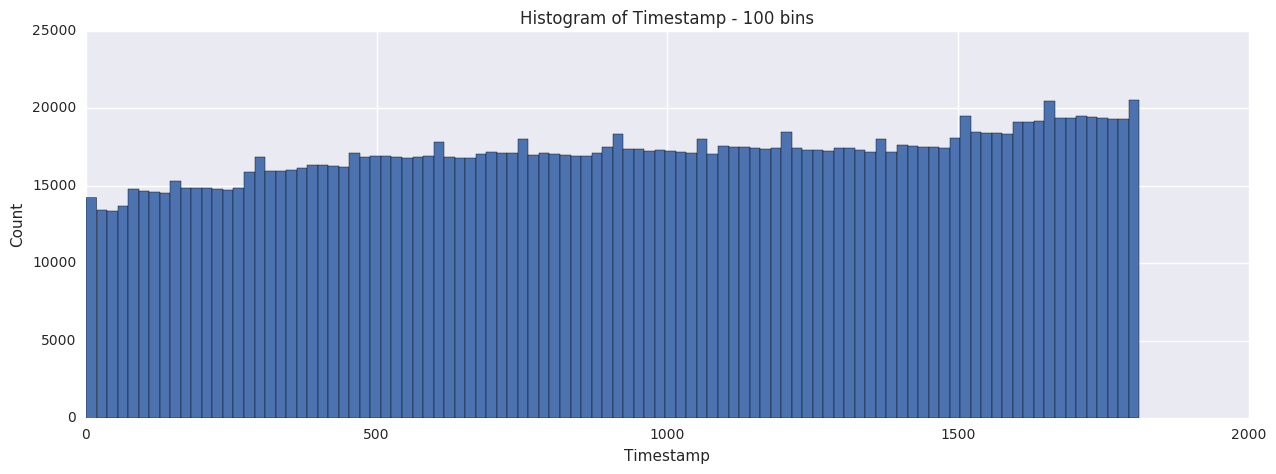

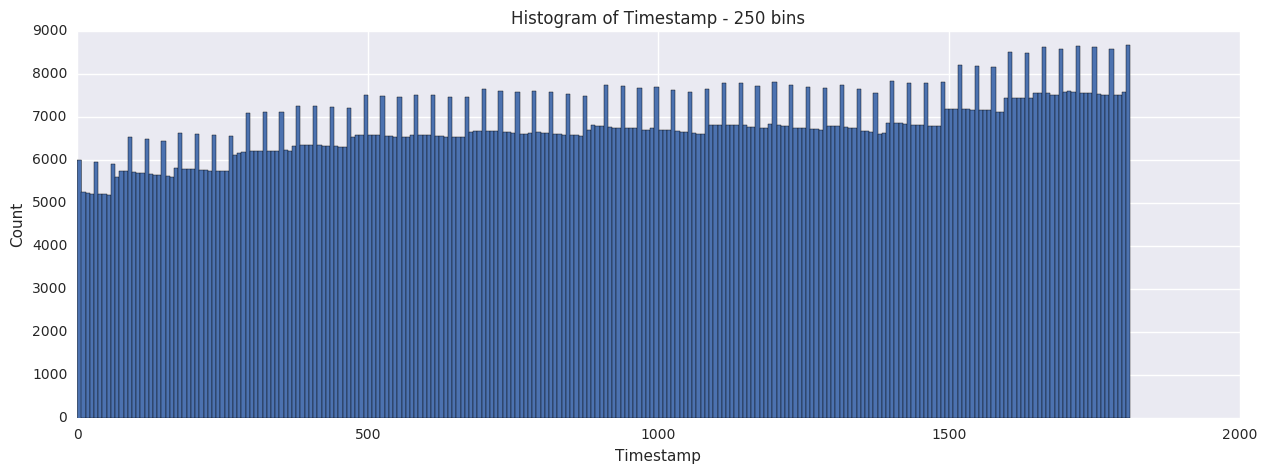

In [7]:
timestamp = df.timestamp.values
for bins in [100, 250]:
    plt.figure(figsize=(15, 5))
    plt.hist(timestamp, bins=bins)
    plt.xlabel('Timestamp')
    plt.ylabel('Count')
    plt.title('Histogram of Timestamp - {} bins'.format(bins))

Now this is _very_ interesting. There appears to be quite a complex structure to the timestamp variable over time. Maybe we can unravel something from it, and maybe figure out what the real-life time period is.

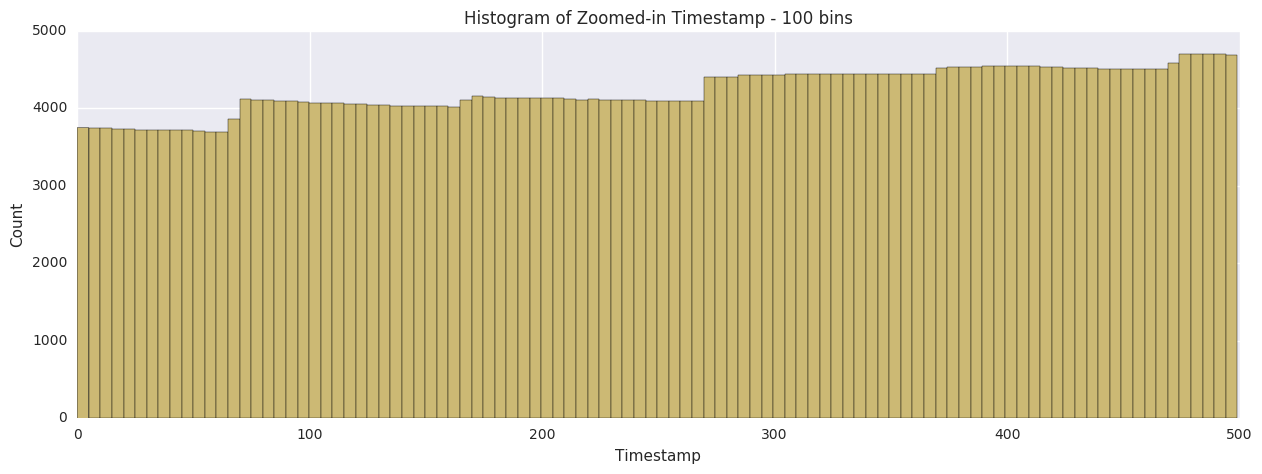

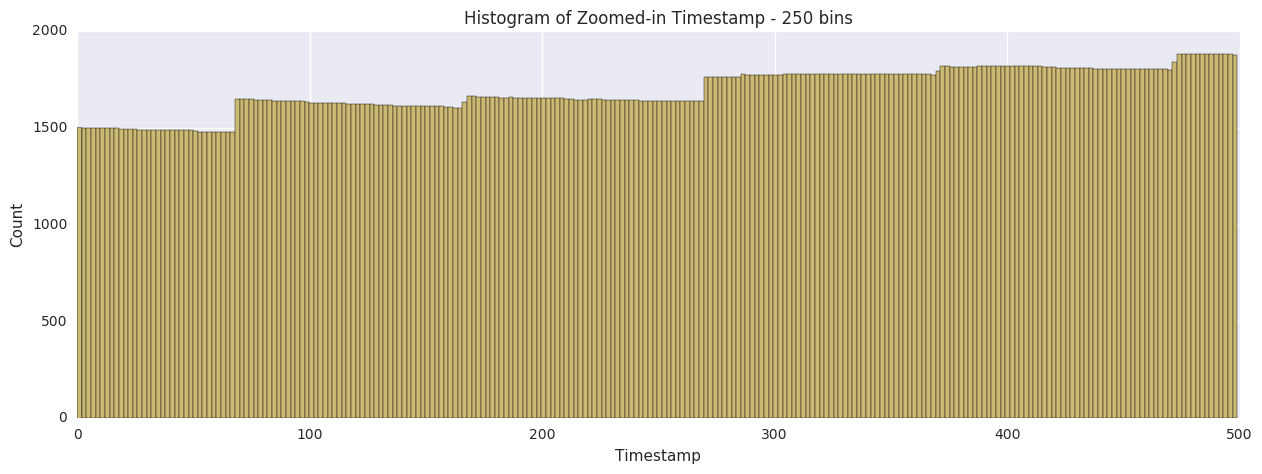

In [8]:
time_mini = df.timestamp.loc[df.timestamp < 500].values
for bins in [100, 250]:
    plt.figure(figsize=(15, 5))
    plt.hist(time_mini, bins=bins, color=p[4])
    plt.xlabel('Timestamp')
    plt.ylabel('Count')
    plt.title('Histogram of Zoomed-in Timestamp - {} bins'.format(bins))

I can see here that the count of timestamp tends to decrease slightly for about 100 'timestamps', and then jumps up afterwards. My hypothesis is that this jump could signify the start of the next day or similar. Let's try to look at these jumps in more detail.

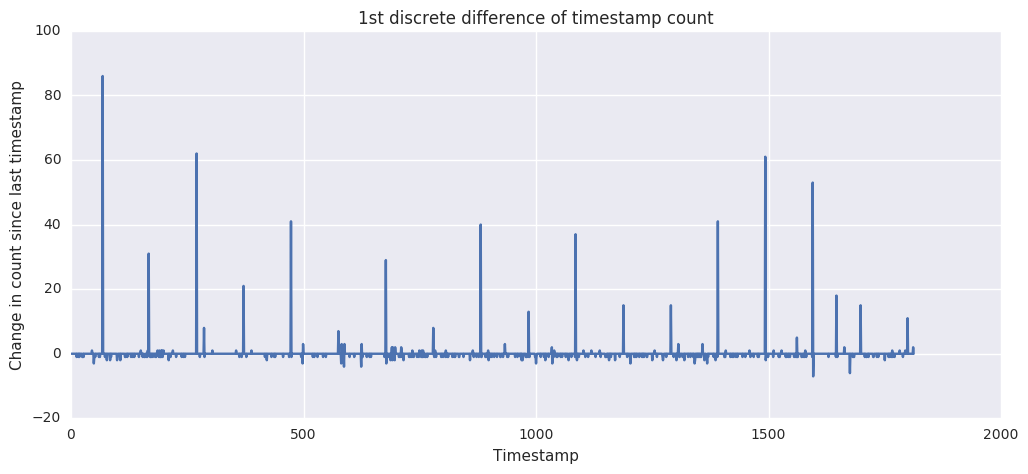

In [9]:
timediff = df.groupby('timestamp')['timestamp'].count().diff()
plt.figure(figsize=(12, 5))
plt.plot(timediff)
plt.xlabel('Timestamp')
plt.ylabel('Change in count since last timestamp')
plt.title('1st discrete difference of timestamp count')

Okay, there's definitely some structure here. Let's measure the distance between the peaks, defining a peak as a point where the count increases by more than 10.


In [10]:
pd.Series(timediff[timediff > 10].index).diff()

0       NaN
1      99.0
2     103.0
3     101.0
4     102.0
5     204.0
6     204.0
7     103.0
8     101.0
9     103.0
10    102.0
11    101.0
12    102.0
13    102.0
14     51.0
15     52.0
16    101.0
Name: timestamp, dtype: float64

This basically confirms that the timestamp has a time period of 100. We can see that almost all the peaks are 100 timestamps apart, with two of them being 200 timestamps apart, and two of them being 50 timestamps apart. Looking at the graph above, we can also see that in the two cases where the period is 200, there is actually a peak 100 timestamps in which is smaller than 100.

In [11]:
print(timediff[timediff > 10].index[0])

68


We can approximate where the peaks will be with a function `100x + 70` (there is a gap of 100 between each peak, with an offset of 70.)

This information could be used to quite accurately predict what the count of the timestamp will be in the future.

## Change in the target value over time

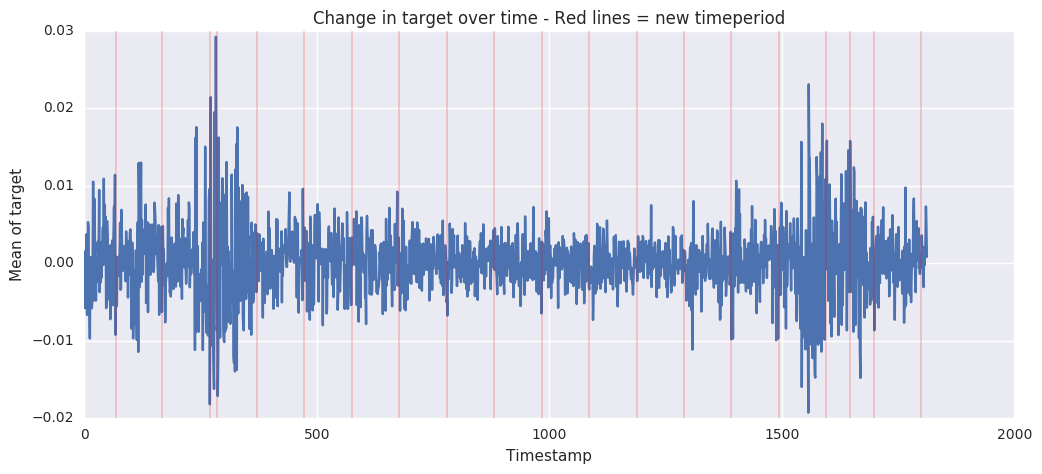

In [12]:
time_targets = df.groupby('timestamp')['y'].mean()
plt.figure(figsize=(12, 5))
plt.plot(time_targets)
plt.xlabel('Timestamp')
plt.ylabel('Mean of target')
plt.title('Change in target over time - Red lines = new timeperiod')
for i in timediff[timediff > 5].index:
    plt.axvline(x=i, linewidth=0.25, color='red')

There doesn't seem to be _too_ much of a pattern to the target value, except for those two, very apparent, peaks in variability. It looks like the time series aspect will be very important.

It also appears to me that the start of a new time period very often coincides with (at least a small) peak in the data. Anyone else see this, or am I mentally overfitting? :)

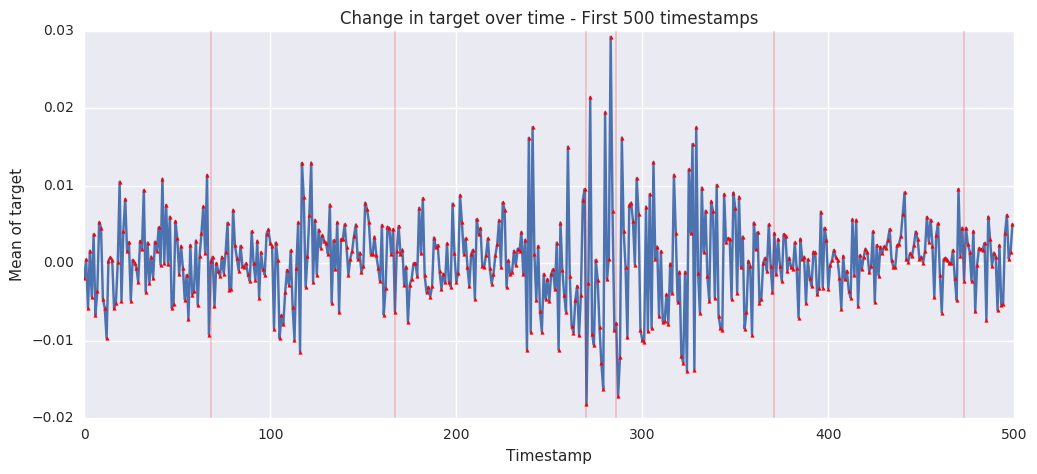

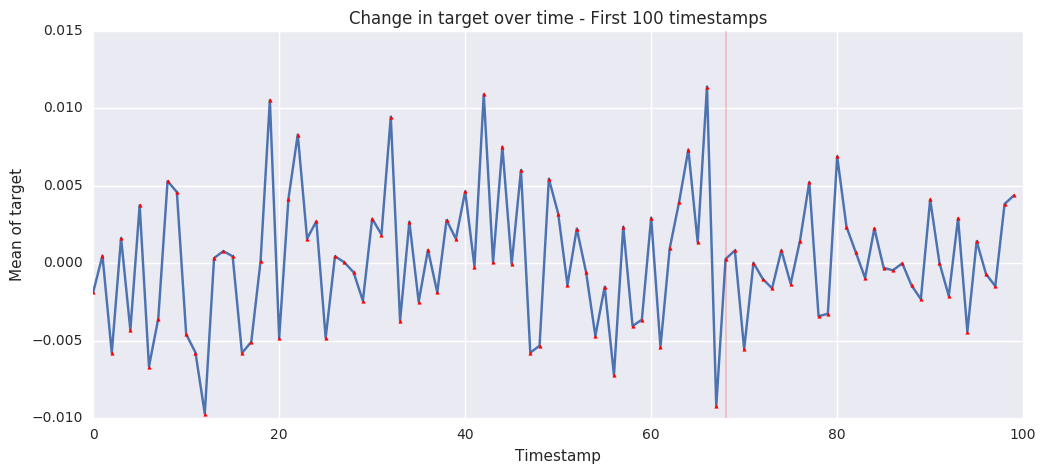

In [13]:
for i in [500, 100]:
    time_targets = df.groupby('timestamp')['y'].mean()[:i]
    plt.figure(figsize=(12, 5))
    plt.plot(time_targets, color=p[0], marker='^', markersize=3, mfc='red')
    plt.xlabel('Timestamp')
    plt.ylabel('Mean of target')
    plt.title('Change in target over time - First {} timestamps'.format(i))
    for i in timediff[:i][timediff > 5].index:
        plt.axvline(x=i, linewidth=0.25, color='red')

Don't see very much pattern on a very zoomed in scale, it seems pretty random to me. Maybe looking at it on such a small scale isn't the right approach ;)

I can't do any more analysis right now as the kernels are being ridiculously unreliable - losing connection every minute or two - and I lose my work every time :'(